In [1]:
import numpy as np
import pandas as pd

In [2]:
# overview of the data
data = pd.read_csv("./dataset/heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# get a summary of the number of discrete values in each str column
index = [1, 2, 6, 8, 10]
df = np.loadtxt('./dataset/heart.csv', delimiter=',', skiprows=1, usecols = index, dtype = "str")

for i in range(5):
    print("col:", index[i])
    print(pd.Series(df[:, i]).value_counts(), end="\n\n")

col: 1
M    725
F    193
dtype: int64

col: 2
ASY    496
NAP    203
ATA    173
TA      46
dtype: int64

col: 6
Normal    552
LVH       188
ST        178
dtype: int64

col: 8
N    547
Y    371
dtype: int64

col: 10
Flat    460
Up      395
Down     63
dtype: int64



In [4]:
from util import load_data, add_theta_0
from sklearn.preprocessing import StandardScaler

# load data
x = np.loadtxt("./dataset/heart.csv", usecols = range(11), skiprows = 1, dtype = "str", delimiter=',')
y = np.loadtxt("./dataset/heart.csv", usecols = range(11, 12), skiprows = 1, dtype = "str", delimiter=',')


# convert str into int
m, n = x.shape
d0 = {"M": 1, "F": 0}
d1 = {"ASY": 1, "NAP": 2, "ATA": 3, "TA": 4}
d2 = {"Normal": 1, "ST": 2, "LVH": 3}
d3 = {"Y": 1, "N": 0}
d4 = {"Up": 1, "Flat": 2, "Down": 3}
for i in range(m):
    x[i, 1] = d0[x[i, 1]]
    x[i, 2] = d1[x[i, 2]]
    x[i, 6] = d2[x[i, 6]]
    x[i, 8] = d3[x[i, 8]]
    x[i, 10] = d4[x[i, 10]]
    
x = x.astype(float)
y = y.astype(float)

# feature scaling
scaler = StandardScaler().fit(x)
x = scaler.transform(x)

# add intercept
#x = add_theta_0(x)

print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (918, 11)
y shape: (918,)


In [5]:
# this section contains randomo_forest and its helpers
import random
import math
import time
import sys

# returns a random forest (treeLength number of trees)
def random_forest(data, features, max_depth, treeLength, labels):
    decision_trees = list()
    start = time.time()
    
    # build trees one by one
    for i in range(treeLength):
        # update progress bar
        sys.stdout.write('\r')
        sys.stdout.write("[%-21s] %d%%  %.2fs    " % 
                         ('='* round(i * 20/treeLength) + ">", 100/treeLength * i, time.time() - start))
        
        # build_tree
        decision_trees.append(build_tree(data, range(data.shape[0]), features, max_depth + 1, 0, labels, -1))
    
    # update progress bar to 100%
    sys.stdout.write('\r')
    sys.stdout.write("[%-21s] %d%%  %.2fs    " % ('='* 20 + ">", 100, time.time() - start))
    
    return decision_trees


# build a decision tree
def build_tree(data, index, features, max_depth, depth, labels, prev_gini):
    # check if we have reached the maximum depth or there are not no features
    if depth == max_depth or features == 0:
        return
    
    # randomly select sqrt(features) from all features
    feature_sample = random.sample(range(features), round(math.sqrt(features)))
    decision_f, decision_b, decision_groups, min_sub_gini = 0, 0, list(), list()
    min_gini = 2
    
    # find split boundary by looping through all values of each sampled feature
    for f in feature_sample:
        freq = pd.Series(data[index, f]).value_counts().to_dict()
        for key, value in freq.items():
            sub_groups = split(data, index, key, f)
            gini, sub_gini = get_gini(data, sub_groups, labels)
            
            # update decision feature and boundary if gini index is less then the previous minimum
            if gini < min_gini:
                decision_f, decision_b, decision_groups, min_gini, min_sub_gini = f, key, sub_groups, gini, sub_gini
    
    # fill in attributes of the current node
    left, right = decision_groups
    root = Node()
    root.feature = decision_f
    root.boundary = decision_b 
    
    # contruct children if both left and right sub groups have a positive length
    #     and the weighted gini index of sub groups are less than the gini index of the current node
    if len(left) > 0 and len(right) > 0:
        if min_gini < prev_gini or prev_gini < 0:
            root.left = build_tree(data, left, features, max_depth, depth + 1, labels, min_sub_gini[0])
            root.right = build_tree(data, right, features, max_depth, depth + 1, labels, min_sub_gini[1])

    # find the label of the node (majority class) if we are at a leaf node 
    if not root.left and not root.right:
        max_p = -1
        max_label = 0
        for label in labels:
            p = list(data[index, -1]).count(label) / index.shape[0]
            if p > max_p:
                max_label, max_p = label, p
                
        root.label = max_label
        
    return root

# split data into two groups based on feature and the decision boundary
#     return two lists consisting of index of the dataset
def split(data, idx, boundary, feature):
    left = np.where(data[idx, feature] < boundary, idx, -1)
    left = left[left >= 0]
    right = np.where(data[idx, feature] >= boundary, idx, -1)
    right = right[right >= 0]

    return left, right

# calclate the weighted gini index of the a split and the gini index of each element of groups
def get_gini(data, groups, labels):
    length_list = list()
    list_length = sum([len(g) for g in groups])
    
    sub_gini = list()
    score_sum = 0
    for g in groups:
        score = 0
        length = len(g)
        if length != 0:
            for label in labels:
                score += (list(data[g, -1]).count(label) / length)**2
        sub_gini.append(1 - score)
        score_sum += score * (length / list_length)
        
    return 1 - score_sum, sub_gini

# define class node which stores the decision feature, boundary, left and right subtrees and its label at leaf node 
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = 0
        self.boundary = 0
        self.label = None


In [6]:
from random import randrange
from statistics import mode

# classify x based on the decision tree at root
def classify(root, x):
    # return the node label if we are at a leaf node
    if not root.left and not root.right:
        return(root.label)
    
    # go to left or right sub tree based on the value of feature
    if x[root.feature] < root.boundary:
        return classify(root.left, x)
    else:
        return classify(root.right, x)
    
# split dataset into n_folds number of folds
#    all folds have the same number of data and they store index of dataset instead of the original data
def cross_val_split(dataset, n_folds):
    length = data.shape[0]
    set = np.array(range(length))
    fold_size = math.floor(length / n_folds)
    datasets = list()
    
    # random sample each fold one by one
    for i in range(n_folds):
        idx = np.random.choice(length, size=fold_size, replace=False)
        length -= fold_size
        datasets.append(list(dataset[set[idx]]))
        set = np.delete(set, idx)
        
    return datasets
        
# evaluate algo by performing (n-fold)-fold cross-validation on dataset
def evaluate(dataset, feature, algo, n_folds, max_depth, treeLength, labels):
    folds = cross_val_split(dataset, n_folds)
    scores = list()
    
    for i in range(n_folds):
        # prepare train_set and test_set
        train_set = np.delete(np.array(folds), i, axis=0)
        test_set = np.array(folds[i])
        train_set = train_set.reshape(train_set.shape[0] * train_set.shape[1], train_set.shape[2])
        
        # sample a proportion of data used in training to reduce overfitting
        train_sample = np.random.choice(train_set.shape[0], size = round(train_set.shape[0] * 0.7), replace=False)

        # build random_forest
        trees = algo(train_set[train_sample, :], feature, max_depth, treeLength, labels)
        
        # calculate accuracy on the train set
        train_predicted = [predict(trees, r) for r in train_set]
        train_actual = train_set[:, -1]
        train_accuracy = get_accuracy(train_actual, np.array(train_predicted).reshape(-1, ))
        print("train accuracy: {:.2f}%".format(train_accuracy * 100), end="    ")
        
        # calculate accuracy on the test set
        val_predicted = [predict(trees, r) for r in test_set]
        val_actual = test_set[:, -1]
        val_accuracy = get_accuracy(val_actual, np.array(val_predicted).reshape(-1, ))
        scores.append(val_accuracy)
        print("val. accuracy: {:.2f}%".format(val_accuracy * 100))
    
    print(scores)
    print("Mean Accuracy: {:.2f}%".format(sum(scores) / len(scores) * 100))

# return the accuracy (proportaion of data in which predicted matches actual)
def get_accuracy(actual, predicted):
    return 1 - ((actual - predicted).T.dot(actual - predicted) / len(actual))

# predict x using trees
def predict(trees, x):
    predictions = list()
    prediction = [classify(trees[j], x) for j in range(len(trees))]
    predictions.append(mode(prediction))
    
    return predictions

In [7]:
evaluate(np.append(x, y.reshape(-1, 1), axis = 1), x.shape[1], random_forest, 10, 6, 50, range(2))
#random_forest(data, features, max_depth, treeLength, labels)

[====================>] 100%  14.32s    train accuracy: 90.96%    val. accuracy: 91.21%
[====================>] 100%  14.20s    train accuracy: 92.43%    val. accuracy: 83.52%
[====================>] 100%  14.64s    train accuracy: 91.82%    val. accuracy: 87.91%
[====================>] 100%  14.22s    train accuracy: 91.45%    val. accuracy: 89.01%
[====================>] 100%  13.99s    train accuracy: 91.94%    val. accuracy: 79.12%
[====================>] 100%  14.22s    train accuracy: 91.21%    val. accuracy: 89.01%
[====================>] 100%  14.26s    train accuracy: 91.45%    val. accuracy: 91.21%
[====================>] 100%  13.36s    train accuracy: 90.23%    val. accuracy: 83.52%
[====================>] 100%  13.32s    train accuracy: 92.80%    val. accuracy: 82.42%
[====================>] 100%  14.53s    train accuracy: 93.28%    val. accuracy: 87.91%
[0.9120879120879121, 0.8351648351648352, 0.8791208791208791, 0.8901098901098901, 0.7912087912087912, 0.8901098901098901,

In [8]:
# this sections tries to find the best hyperparameters using the sklearn library

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate

# define possible values of hypterparameters
n = np.array([5, 10, 20, 50, 100, 200])
depth = np.array([1, 2, 3, 4, 5, 6, 7, 8])

mean = list()

# loop trough all combinations of hyperparameters defined above and store their information in mean
for i in range(n.shape[0]):
    for j in range(depth.shape[0]):
        model = RandomForestClassifier(n_estimators=n[i], max_depth=depth[j], random_state=0)
        cv = cross_validate(model, x, y, cv=10, return_train_score=True)
        mean.append(np.array([n[i], depth[j], np.mean(cv['train_score']), np.mean(cv['test_score'])]))

best parameters:   n: 50.0 depth: 6.0 train accuracy: 0.930161674244842 val. accuracy: 0.8592689918776875


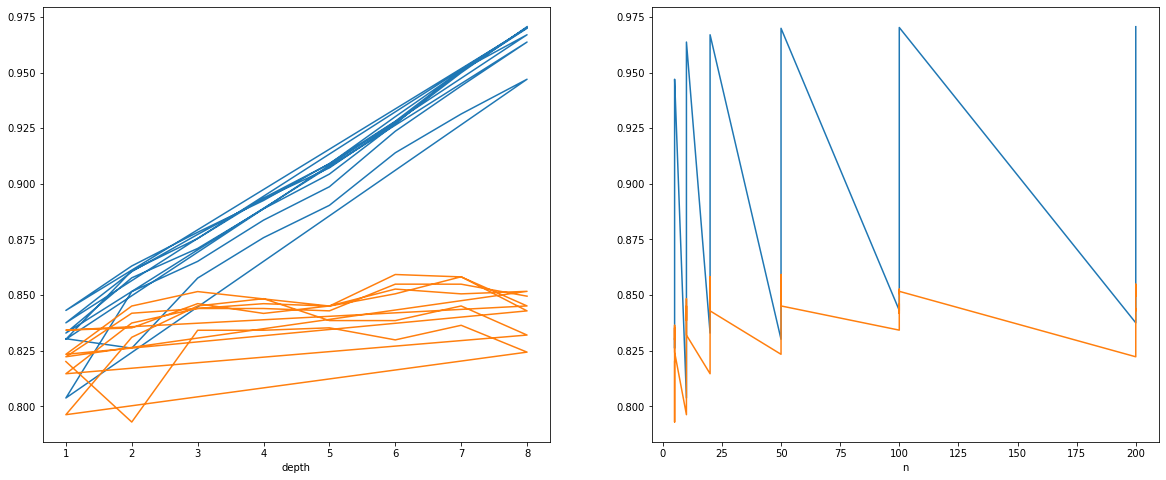

In [11]:
import matplotlib.pyplot as plt

m = np.array(mean)
best = m[np.argmax(m[:, 3])]
print("best parameters:   n:", best[0], "depth:", best[1], "train accuracy:", best[2], "val. accuracy:", best[3])

# print graphs which gives a visual representation of the relationship bewteen each hyperparameter and accuracy
figure, axis = plt.subplots(1, 2)
figure.set_size_inches(20, 8)
axis[0].set_xlabel("depth")
axis[0].plot(m[:, 1], m[:, 2])
axis[0].plot(m[:, 1], m[:, 3])
axis[1].set_xlabel("n")
axis[1].plot(m[:, 0], m[:, 2])
axis[1].plot(m[:, 0], m[:, 3])


plt.show()